In [1]:
pip install mne neptune neptune_pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt

import numpy as np
import random
import mne

import torch
from torch.utils.data.dataset import Dataset
#import eegCompressModels
#import imp
#imp.reload(eegCompressModels)

import neptune
from neptune_pytorch import NeptuneLogger

import datetime
import pytz
timeZone = pytz.timezone('America/Los_Angeles')

In [4]:
def imageCompare(start, channel = 0, plotOption="both"):

    original = data[channel,start:start + numSampleInput]

    modelInput = np.reshape(data[:, start:start + numSampleInput], (inSize, -1), order='F').astype('float32').flatten()
    encoded = model.encoder(torch.tensor(modelInput))
    decoded = np.reshape(model.decoder(encoded).detach().numpy(), (nChannel, numSampleInput),order="F")[channel, :]

    fig = plt.figure()
    if plotOption == "both":
        plt.plot(range(start, start + numSampleInput), original, label='original')
        plt.plot(range(start, start + numSampleInput), decoded, label='decoded')
        plt.ylim([-1,1])
        plt.legend()
    elif plotOption == "orig":
        plt.plot(original)
        plt.ylim([-1,1])
        plt.title('original')
    else:
        plt.plot(decoded)
        plt.ylim([-1,1])
        plt.title('decoded')

    return fig, encoded, decoded

def sizeToLayerList(encoderSizeList,
					decoderSizeList,
					encoderActivationList,
					decoderActivationList):
	encoderLayerList = []
	decoderLayerList = []

	for i in range(0, len(encoderSizeList) - 1):
		thisLayer = torch.nn.Linear(encoderSizeList[i], encoderSizeList[i + 1])
		torch.nn.init.xavier_uniform_(thisLayer.weight)

		encoderLayerList.append(thisLayer)
		if encoderActivationList[i]:
			encoderLayerList.append(torch.nn.ReLU())

	#decoderSizeList = [encoderSizeList[-2]] + decoderSizeList
	for i in range(0, len(decoderSizeList) - 1):
		thisLayer = torch.nn.Linear(decoderSizeList[i], decoderSizeList[i + 1])
		torch.nn.init.xavier_uniform_(thisLayer.weight)

		decoderLayerList.append(thisLayer)
		if decoderActivationList[i]:
			decoderLayerList.append(torch.nn.ReLU())

	return encoderLayerList, decoderLayerList

class AE(torch.nn.Module):
	def __init__(self, encoderSizeList, decoderSizeList, encoderActivationList, decoderActivationList):
		super().__init__()

		encoderLayerList, decoderLayerList = sizeToLayerList(encoderSizeList,
															decoderSizeList,
															encoderActivationList,
															decoderActivationList)

		self.encoder = torch.nn.Sequential(*encoderLayerList)
		self.decoder = torch.nn.Sequential(*decoderLayerList)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded

class CustomDataset(Dataset):
  def __init__(self, eegNumpy, numSampleInput):
    self.eegNumpy = eegNumpy
    self.numSampleInput = numSampleInput
    self.nChannel, self.nSample = eegNumpy.shape

  def __len__(self):
    return int(self.nSample/self.numSampleInput)
		#return self.nSample - self.numSampleInput

  def __getitem__(self, idx):
    image = np.reshape(self.eegNumpy[:,idx * numSampleInput : (idx + 1) * numSampleInput], (self.nChannel * self.numSampleInput,-1), order='F').transpose().astype('float32')
    #image = np.reshape(self.eegNumpy[:,idx:idx + self.numSampleInput], (self.nChannel * self.numSampleInput,-1), order='F').transpose().astype('float32')
    return image, 0


### EEG data

In [5]:
raw = mne.io.read_raw_edf('/content/drive/MyDrive/NeuroResearch/Data/eegCompress/SVD001.edf')

Extracting EDF parameters from /content/drive/MyDrive/NeuroResearch/Data/eegCompress/SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-c06354f32ef6>:1: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('/content/drive/MyDrive/NeuroResearch/Data/eegCompress/SVD001.edf')


In [6]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~40 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [7]:
chanList = range(0,19)
nChannel = len(chanList)

data = raw.get_data()[chanList] #eeg channels
_, nSample = data.shape
print(data.shape)

(19, 1276416)


In [8]:
for i in range(nChannel):
    data[i,:] = (data[i,:] - np.mean(data[i,:])) / np.std(data[i,:])

### Random data

In [9]:
'''
data = np.random.random((1,100000))
data = data - np.mean(data)
data = data/np.std(data)
nChannel = data.shape[0]
'''

'\ndata = np.random.random((1,100000))\ndata = data - np.mean(data)\ndata = data/np.std(data)\nnChannel = data.shape[0]\n'

### Define Model, etc.

In [10]:
# Set in/out parameters
numSampleInput = 5
outSizeRatio = .8

inSize = nChannel * numSampleInput
outSize = int(inSize * outSizeRatio)
print(inSize, outSize)

# Construct the DataLoader
dataset = CustomDataset(data, numSampleInput)
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Make the model
encoderSizeList = [inSize, outSize]
decoderSizeList = [outSize, inSize]
encoderActivationList = [False]
decoderActivationList = [False]

model = AE(encoderSizeList, decoderSizeList, encoderActivationList, decoderActivationList)
print(model)
loss_function = torch.nn.MSELoss()

95 76
AE(
  (encoder): Sequential(
    (0): Linear(in_features=95, out_features=76, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=76, out_features=95, bias=True)
  )
)


In [11]:
run = neptune.init_run(
    project="jettinger35/eegCompress",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjFlMzY2MS1iOWZiLTRmZWEtOGMwNy0zOTVkMTljOGVjYTMifQ==",
)

npt_logger = NeptuneLogger(
    run=run,
    model=model)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jettinger35/eegCompress/e/EEG-107


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)
#optimizer = torch.optim.Adam(model.parameters())#, lr = 1e-1, weight_decay = 1e-8)

totalEpoch = 0

In [13]:
epochs = 40
numSamplePlot = 3

for epoch in range(epochs):
	for (image, _) in loader:
		# Output of Autoencoder
		reconstructed = model(image.to(torch.float32))
		# Calculating the loss function
		loss = loss_function(reconstructed, image)

		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		run[npt_logger.base_namespace]["train/log_loss"].append(np.log(loss.item()))

	for i in range(numSamplePlot):
		startPlot = random.randint(0, nSample - numSampleInput)
		fig, _, _ = imageCompare(startPlot)
		plt.title("Total Epoch: " + str(totalEpoch))
		run["fig"].append(fig)
		plt.close()

	totalEpoch += 1

torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, '/content/drive/MyDrive/Colab Notebooks/savedModel_' + str(datetime.datetime.now().astimezone(timeZone)))
print("Model has been saved....")

Model has been saved....


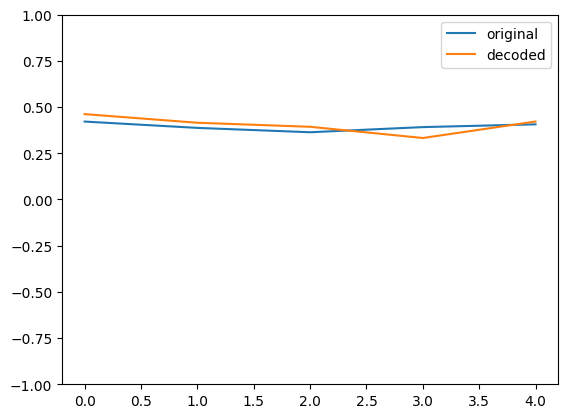

In [68]:
startPlot = 0
fig, encoded, decoded = imageCompare(startPlot)
plt.show(fig)

In [ ]:
list(model.parameters())[0].grad

In [18]:
for name, param in model.named_parameters():
    print((name, param))

('encoder.0.weight', Parameter containing:
tensor([[ 0.2833, -0.1527, -0.0664,  ...,  0.0699,  0.0502, -0.1362],
        [ 0.0934, -0.0641,  0.1850,  ..., -0.0131, -0.0777,  0.0605],
        [-0.1205, -0.1093, -0.0830,  ...,  0.1054, -0.1907, -0.1182],
        ...,
        [ 0.1466,  0.0154, -0.0466,  ..., -0.1258, -0.1466, -0.1624],
        [-0.0430,  0.0618, -0.0483,  ..., -0.0540, -0.0659, -0.1408],
        [-0.1286,  0.3222,  0.0307,  ..., -0.0536, -0.0371,  0.1358]],
       requires_grad=True))
('encoder.0.bias', Parameter containing:
tensor([-0.0132, -0.0468,  0.0264,  0.0218, -0.0234, -0.0306,  0.0267,  0.0012,
         0.0084, -0.0063,  0.0214,  0.0257, -0.0779,  0.0497, -0.0018,  0.0513,
         0.0203, -0.0389,  0.0336, -0.0024,  0.0410,  0.0852,  0.0078, -0.0170,
         0.0184, -0.0228, -0.0346, -0.0328, -0.0217,  0.0677,  0.0488,  0.0541,
        -0.0026, -0.0480,  0.0034,  0.0427,  0.0140, -0.0155, -0.0763, -0.0149,
        -0.0038, -0.0309,  0.0490, -0.0328, -0.0273, -

### Misc